In [1]:
# Import statements
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import pandas as pd
from statsmodels.tsa.stattools import acf

In [2]:
# Main SEIR function
def gillespie_seir(N, beta_func, delta, gamma, mu, initial_infected, initial_exposed, max_time, *beta_args):
    # Initial conditions
    S = N - initial_infected - initial_exposed
    E = initial_exposed
    I = initial_infected
    R = 0
    
    # Arrays to store results
    times = np.zeros(1000000)
    susceptible = np.zeros(1000000)
    susceptible[0] = S
    exposed = np.zeros(1000000)
    exposed[0] = E
    infected = np.zeros(1000000)
    infected[0] = I
    recovered = np.zeros(1000000)
    recovered[0] = R
    
    t = 0
    ind = 0
    beta = beta_func(t, beta_args)
    while t < max_time:
        # Calculate rates (transmission, symptom onset, recovery, birth and deaths)
        beta = beta_func(t, beta_args)
        lambda_SE = beta * S * I / N
        lambda_EI = delta * E
        lambda_IR = gamma * I
        lambda_birth = mu * N
        lambda_death_S = mu * S
        lambda_death_E = mu * E
        lambda_death_I = mu * I
        lambda_death_R = mu * R
        total_rate = (lambda_SE + lambda_EI + lambda_IR + lambda_birth +
                      lambda_death_S + lambda_death_E + lambda_death_I + lambda_death_R)
        
        if total_rate == 0:
            break
        
        # Calculate time step
        dt = np.random.exponential(1 / total_rate)
        t += dt
        ind += 1
        
        # Determine which event occurs
        rand = np.random.rand() * total_rate
        
        # Work out which event had happened
        if rand < lambda_SE:
            S -= 1
            E += 1
        elif rand < lambda_SE + lambda_EI:
            E -= 1
            I += 1
        elif rand < lambda_SE + lambda_EI + lambda_IR:
            I -= 1
            R += 1
        elif rand < lambda_SE + lambda_EI + lambda_IR + lambda_birth:
            S += 1
        else:
            rand_death = rand - (lambda_SE + lambda_EI + lambda_IR + lambda_birth)
            if rand_death < lambda_death_S:
                S -= 1
            elif rand_death < lambda_death_S + lambda_death_E:
                E -= 1
            elif rand_death < lambda_death_S + lambda_death_E + lambda_death_I:
                I -= 1
            else:
                R -= 1
        
        # Append results
        times[ind] = t
        susceptible[ind] = S
        exposed[ind] = E
        infected[ind] = I
        recovered[ind] = R
    
    return times[:ind+1], susceptible[:ind+1], exposed[:ind+1], infected[:ind+1], recovered[:ind+1]

In [3]:
# Four beta(t) functions for the simulations: 
# Constant, increasing gradually, decreasing gradually, step-decrease
def beta_constant(t, beta0):
    return beta0[0]

def beta_increasing(t, *beta_args):
    beta0, p, tau, beta1 = beta_args[0]
    betat = beta0+p*(t-tau) if t > tau else beta0
    if betat >= beta1:
        return beta1
    else:
        return betat

def beta_decreasing(t, *beta_args):
    beta0, p, tau, beta1 = beta_args[0]
    betat = beta0-p*(t-tau) if t > tau else beta0
    if betat <= beta1:
        return beta1
    else:
        return betat

def beta_step(t, *beta_args):
    beta0, beta1, tau = beta_args[0]
    return beta0 if t<tau else beta1

$R_0 = \dfrac{\beta\delta}{(\delta+\mu)(\gamma+\mu)}\Rightarrow \beta = \dfrac{R_0(\delta+\mu)(\gamma+\mu)}{\delta}$

In [5]:
# Constant Parameters
N = 1e5  # Total population
delta = 1/5 # Symptom onset rate (1/delta is the infectious)
gamma = 1/10  # Recovery rate (1/gamma is the infectious period)
R_0 = 4 # Basic reproduction number estimated for alpha variant
mu = 0.00003424657  # Birth and death rate
initial_infected = 50
initial_exposed = 0
max_time = 200
beta0 = R_0 * (delta+mu)*(gamma+mu)/delta
num_res = 100
print(beta0)

beta_trans = 1 * (delta+mu)*(gamma+mu)/delta
print(beta_trans)

0.40020550287655116
0.10005137571913779


## Constant sim: $\beta(t)=\beta_0$
## Increasing sim: $\beta(t)=\beta_0+p*(t-\tau)$
## Decreasing sim: $\beta(t)=\beta_0-p$
## Step sim: $\beta(t)=\beta_0(1-H(t-\tau))+\beta_1(H(t-\tau))$

In [6]:
betalow_inc = 0.05
(beta0-betalow_inc)/30

0.011673516762551706

In [7]:
# Run simulation
def constant_sim(alg):
    return alg(N, beta_constant, delta, gamma, mu, initial_infected, initial_exposed, max_time, beta0)

runs = [gillespie_seir for i in range(num_res)]

with Pool(12) as pool:
    res = pool.map(constant_sim, runs)

times = np.arange(0,max_time+0.1,0.1)
I_constant = np.zeros((num_res,len(times)))
Reff_constant = np.zeros((num_res,len(times)))
for i in range(num_res):
    I_constant[i,:] = np.interp(times,res[i][0],res[i][3])/N
    Reff_constant[i,:] = np.interp(times,res[i][0],res[i][1])/N * R_0


# Run simulation
betalow_inc = 0.05
p_inc = (beta0-betalow_inc)/30
tau = 30
def increasing_sim(alg):
    return alg(N, beta_increasing, delta, gamma, mu, initial_infected, initial_exposed, max_time, betalow_inc, p_inc, tau, beta0)

with Pool(12) as pool:
    res_increasing = pool.map(increasing_sim, runs)

I_increasing = np.zeros((num_res,len(times)))
Reff_increasing = np.zeros((num_res,len(times)))
for i in range(num_res):
    I_increasing[i,:] = np.interp(times,res_increasing[i][0],res_increasing[i][3]) / N
    Reff_increasing[i,:] = np.interp(times,res_increasing[i][0],res_increasing[i][1])/N * delta/((delta+mu)*(gamma+mu))\
        * np.array([beta_increasing(t,[betalow_inc,p_inc,tau,beta0]) for t in times])


# Run simulation
betalow = 0.05
p_dec = (beta0-betalow)/30
tau_low = 30
def decreasing_sim(alg):
    return alg(N, beta_decreasing, delta, gamma, mu, initial_infected, initial_exposed, max_time, beta0, p_dec, tau_low, betalow)

with Pool(12) as pool:
    res_decreasing = pool.map(decreasing_sim, runs)

times = np.arange(0,max_time+0.1,0.1)
I_decreasing = np.zeros((num_res,len(times)))
Reff_decreasing = np.zeros((num_res,len(times)))
for i in range(num_res):
    I_decreasing[i,:] = np.interp(times,res_decreasing[i][0],res_decreasing[i][3]) / N
    Reff_decreasing[i,:] = np.interp(times,res_decreasing[i][0],res_decreasing[i][1])/N * delta/((delta+mu)*(gamma+mu))\
        * np.array([beta_decreasing(t,[beta0,p_dec,tau_low,betalow]) for t in times])


# Run simulation
# tau = 30
def step_sim(alg):
    return alg(N, beta_step, delta, gamma, mu, initial_infected, initial_exposed, max_time, beta0, betalow, tau)

with Pool(12) as pool:
    res_step = pool.map(step_sim, runs)

I_step = np.zeros((num_res,len(times)))
Reff_step = np.zeros((num_res,len(times)))
for i in range(num_res):
    I_step[i,:] = np.interp(times,res_step[i][0],res_step[i][3]) / N
    Reff_step[i,:] = np.interp(times,res_step[i][0],res_step[i][1]) / N  * delta/((delta+mu)*(gamma+mu))\
        * np.array([beta_step(t,[beta0,betalow,tau]) for t in times])

In [8]:
constant_crit = np.mean(times[np.where(np.abs(np.mean(Reff_constant,axis=0)-1)<=1e-2)])
inc_crit_up = np.mean(times[np.where(np.abs(np.mean(Reff_increasing,axis=0)-1)<=1e-2)][:2])
inc_crit_down = np.mean(times[np.where(np.abs(np.mean(Reff_increasing,axis=0)-1)<=1e-2)][2:])
dec_crit = np.mean(times[np.where(np.abs(np.mean(Reff_decreasing,axis=0)-1)<=1e-2)])
step_crit = tau

In [9]:
df = pd.DataFrame(I_constant).T
stoch_cst = df.sub(df.mean(axis = 1), axis = 'rows')
df_step = pd.DataFrame(I_step).T
stoch_step = df_step.sub(df_step.mean(axis = 1), axis = 'rows')
df_increasing = pd.DataFrame(I_increasing).T
stoch_inc = df_increasing.sub(df_increasing.mean(axis = 1), axis = 'rows')
df_decreasing = pd.DataFrame(I_decreasing).T
stoch_dec = df_decreasing.sub(df_decreasing.mean(axis = 1), axis = 'rows')

In [10]:
# Function to normalise EWS for 2-sigma calculations
def pandas_zscore(dataframe):
    rolling_mean = dataframe.expanding().mean()
    rolling_std = dataframe.expanding().std(ddof=0)
    normalise_stats = (dataframe - rolling_mean)/rolling_std
    return normalise_stats

# Function to calculate EWS on a rolling window for each column
def calculate_ews_rolling(wide_data, window_size):
    ews_data = {}
    acf_data = {}
    rolling = wide_data.rolling(window=window_size,center=False, min_periods=1)
    # variance = (wide_data**2).rolling(window=window_size,center=False, min_periods=1).mean()
    variance = rolling.var()
    first_diff = rolling.var().diff(axis=0)
    ews_data['variance'] = variance
    ews_data['first diff'] = first_diff
    normalised_ews_data = {}
    for ews in ews_data.keys():
        normalised_ews_data[ews] = pandas_zscore(ews_data[ews])
    return ews_data, normalised_ews_data

In [11]:
cst, cst_norm = calculate_ews_rolling(stoch_cst, 7)
inc, inc_norm = calculate_ews_rolling(stoch_inc, 7)
dec, dec_norm = calculate_ews_rolling(stoch_dec, 7)
step, step_norm = calculate_ews_rolling(stoch_step, 7)

In [12]:
def long_run_averages(standardised):
    n = len(standardised)
    running_mean = np.zeros(n)
    running_std= np.zeros(n)
    for j in range(n):
        running_mean[j] = np.nanmean(standardised[1:j+1])
        running_std[j] = np.nanstd(standardised[1:j+1])
    return running_std, running_mean

def exceed_threshold_cutoffs(stat_timeseries, ltla):
    std_val = []
    mean_val = []
    running_std, running_mean = long_run_averages(stat_timeseries[ltla].values)
    std_val = np.concatenate((std_val,running_std))
    mean_val = np.concatenate((mean_val,running_mean))
    # Get indices where stat > mean + 2*sigma and indices where stat < mean - 2*sigma
    stat_timeseries = stat_timeseries[ltla].values
    indices_greater = [ n for n,i in enumerate(range(len(stat_timeseries))) if (stat_timeseries[i])>(mean_val+2*std_val)[i] ]
    indices_smaller =  [ n for n,i in enumerate(range(len(stat_timeseries))) if (stat_timeseries[i])<(mean_val-2*std_val)[i] ]
    all_indices = np.setdiff1d(np.unique(indices_greater + indices_smaller ),[1])    
    return all_indices,mean_val,std_val
    
def loop_EWSs_store_results_cutoffs(ews_dict, ltlas):
    indices_dict = {}
    mean_dict = {}
    std_dict = {}
    for stat in ews_dict.keys():
        indices_dict[stat] = {}
        mean_dict[stat] = {}
        std_dict[stat] = {}
        for ltla in ltlas:
            stat_data = ews_dict[stat][ltla].reset_index()
            indices, mean_val, std_val = exceed_threshold_cutoffs(stat_data, ltla)
            indices_dict[stat][ltla] = indices
            mean_dict[stat][ltla] = mean_val
            std_dict[stat][ltla] = std_val
    return indices_dict, mean_dict, std_dict

In [13]:
ind_cst, mean_cst, std_cst = loop_EWSs_store_results_cutoffs(cst_norm,np.arange(100))
ind_inc, mean_inc, std_inc = loop_EWSs_store_results_cutoffs(inc_norm,np.arange(100))
ind_dec, mean_dec, std_dec = loop_EWSs_store_results_cutoffs(dec_norm,np.arange(100))
ind_step, mean_step, std_step = loop_EWSs_store_results_cutoffs(cst_norm,np.arange(100))

/tmp/ipykernel_43294/1875148048.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_43294/1875148048.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_43294/1875148048.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtyp

In [14]:
# Get detect indices for timeline
from operator import itemgetter

def detect(arr, times):
    if len(arr) < 3:
        return []
    time = []
    values = []
    i = 0
    while i < len(arr) - 2:
        if arr[i] + 1 == arr[i + 1] and arr[i + 1] + 1 == arr[i + 2]:
            values.append(arr[i + 2])
            time.append(times[arr[i+2]])
            # Skip to the end of this sequence of consecutive numbers
            while i + 2 < len(arr) - 1 and arr[i + 2] + 1 == arr[i + 3]:
                i += 1
        i += 1
    
    return values, time

In [15]:
times_cst = {}
times_inc = {}
times_dec = {}
times_step = {}

for sim in np.arange(100):
    _, times_cst[sim] = detect(ind_cst['variance'][sim],times)
    _, times_inc[sim] = detect(ind_inc['variance'][sim],times)
    _, times_dec[sim] = detect(ind_dec['variance'][sim],times)
    _, times_step[sim] = detect(ind_step['variance'][sim],times)

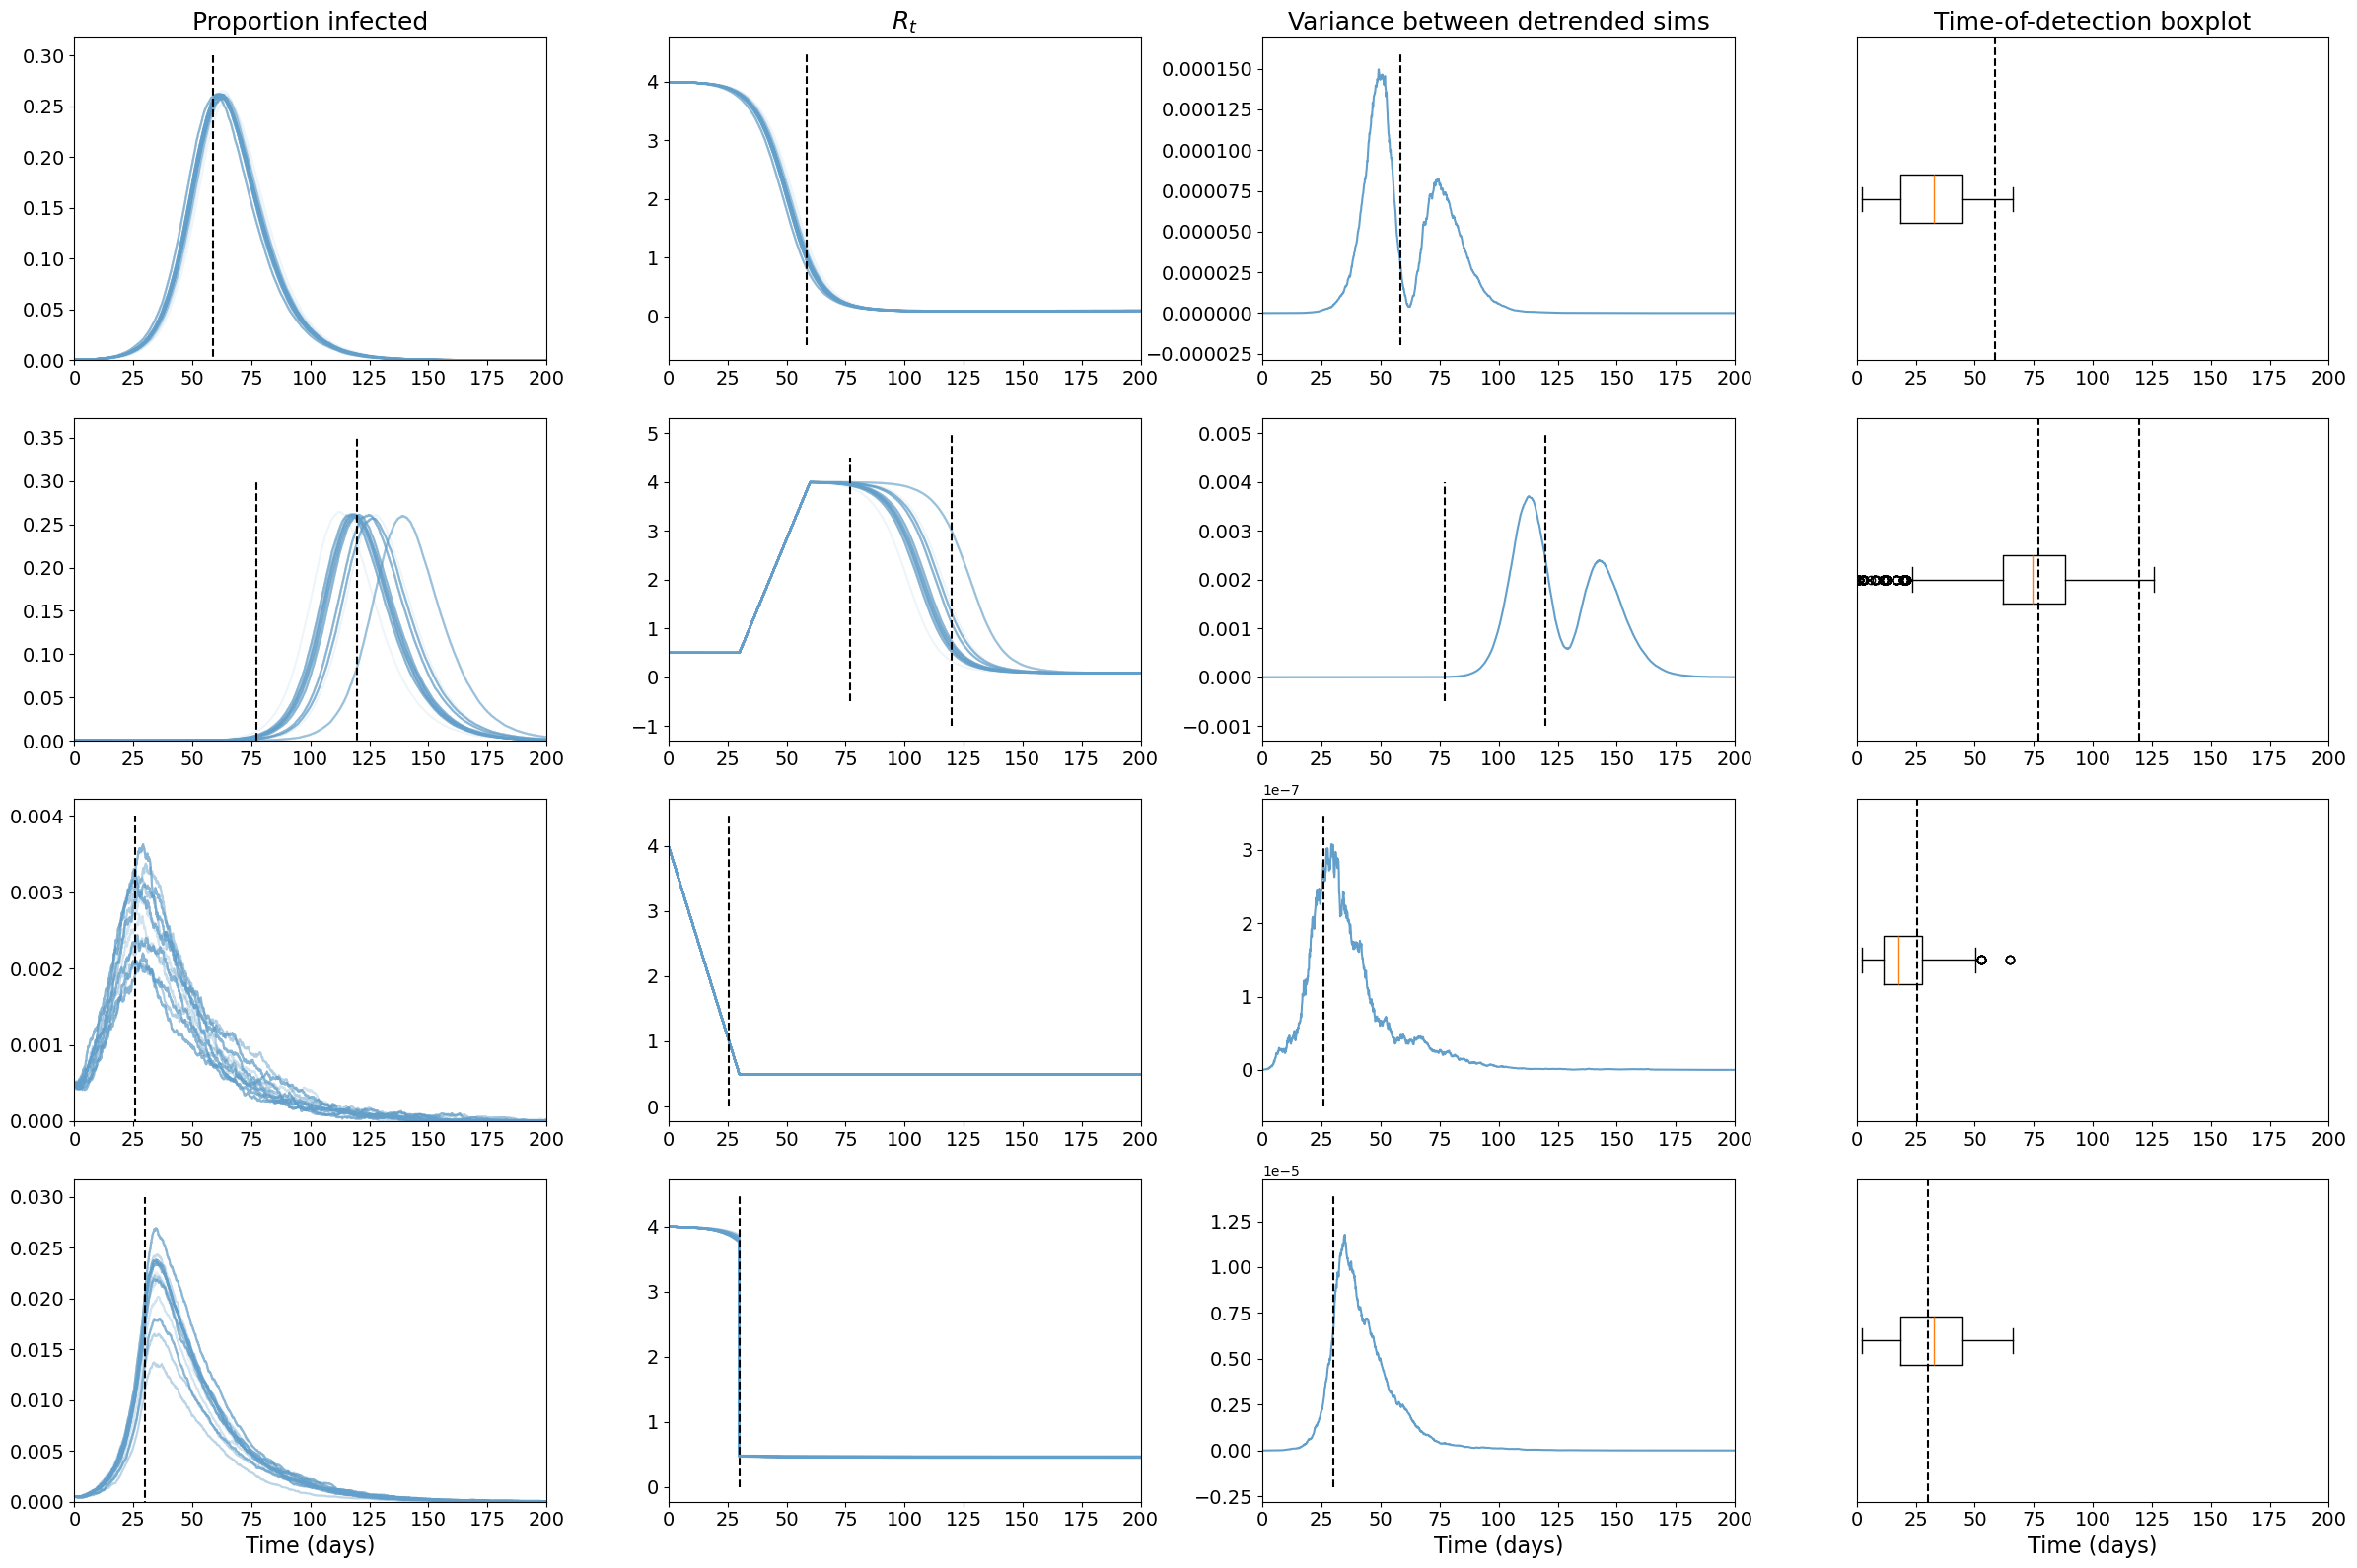

In [17]:
def norm(x):
    rolling_mean = x.expanding().mean()
    rolling_std = x.expanding().std(ddof=0)
    return (x-rolling_mean)/rolling_std

fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize=(24,16))
for i in range(num_res):
    axs[0,0].plot(times,I_constant[i],color='#629FCA',alpha=0.1)
    axs[0,1].plot(times,Reff_constant[i],color='#629FCA',alpha=0.1)
axs[0,2].plot(times,stoch_cst.var(axis=1).values,color='#629FCA')
axs[0,3].boxplot([j for i in times_cst.values() for j in i],vert=False)

axs[0,0].vlines(constant_crit,ymin=axs[0,0].get_yticks()[0],ymax=axs[0,0].get_yticks()[-1],color='k',linestyle='--')
axs[0,1].vlines(constant_crit,ymin=axs[0,1].get_yticks()[0],ymax=axs[0,1].get_yticks()[-1],color='k',linestyle='--')
axs[0,2].vlines(constant_crit,ymin=axs[0,2].get_yticks()[0],ymax=axs[0,2].get_yticks()[-1],color='k',linestyle='--')
axs[0,3].vlines(constant_crit,0.5,1.5,color='k',linestyle='--')

for i in range(num_res):
    axs[1,0].plot(times,I_increasing[i],color='#629FCA',alpha=0.1)
    axs[1,1].plot(times,Reff_increasing[i],color='#629FCA',alpha=0.1)
axs[1,2].plot(times,stoch_inc.var(axis=1).values,color='#629FCA')
axs[1,3].boxplot([j for i in times_inc.values() for j in i],vert=False)


axs[1,0].vlines(inc_crit_up,ymin=axs[1,0].get_yticks()[0],ymax=axs[1,0].get_yticks()[-1],color='k',linestyle='--')
axs[1,1].vlines(inc_crit_up,ymin=axs[1,1].get_yticks()[0],ymax=axs[1,1].get_yticks()[-1],color='k',linestyle='--')
axs[1,2].vlines(inc_crit_up,ymin=axs[1,2].get_yticks()[0],ymax=axs[1,2].get_yticks()[-1],color='k',linestyle='--')
axs[1,3].vlines(inc_crit_up,0.5,1.5,color='k',linestyle='--')
axs[1,0].vlines(inc_crit_down,ymin=axs[1,0].get_yticks()[0],ymax=axs[1,0].get_yticks()[-1],color='k',linestyle='--')
axs[1,1].vlines(inc_crit_down,ymin=axs[1,1].get_yticks()[0],ymax=axs[1,1].get_yticks()[-1],color='k',linestyle='--')
axs[1,2].vlines(inc_crit_down,ymin=axs[1,2].get_yticks()[0],ymax=axs[1,2].get_yticks()[-1],color='k',linestyle='--')
axs[1,3].vlines(inc_crit_down,0.5,1.5,color='k',linestyle='--')

for i in range(num_res):
    axs[2,0].plot(times,I_decreasing[i],color='#629FCA',alpha=0.1)
    axs[2,1].plot(times,Reff_decreasing[i],color='#629FCA',alpha=0.1)
axs[2,2].plot(times,stoch_dec.var(axis=1).values,color='#629FCA')
axs[2,3].boxplot([j for i in times_dec.values() for j in i],vert=False)

axs[2,0].vlines(dec_crit,ymin=axs[2,0].get_yticks()[0],ymax=axs[2,0].get_yticks()[-1],color='k',linestyle='--')
axs[2,1].vlines(dec_crit,ymin=axs[2,1].get_yticks()[0],ymax=axs[2,1].get_yticks()[-1],color='k',linestyle='--')
axs[2,2].vlines(dec_crit,ymin=axs[2,2].get_yticks()[0],ymax=axs[2,2].get_yticks()[-1],color='k',linestyle='--')
axs[2,3].vlines(dec_crit,0.5,1.5,color='k',linestyle='--')

for i in range(num_res):
    axs[3,0].plot(times,I_step[i],color='#629FCA',alpha=0.1)
    axs[3,1].plot(times,Reff_step[i],color='#629FCA',alpha=0.1)
axs[3,0].set_xlabel('Time (days)',fontsize=16)
axs[3,2].plot(times,stoch_step.var(axis=1).values,color='#629FCA')
axs[3,2].set_xlabel('Time (days)',fontsize=16)  
axs[3,3].boxplot([j for i in times_step.values() for j in i],vert=False)
axs[3,3].set_xlabel('Time (days)',fontsize=16)

axs[3,0].vlines(step_crit,ymin=axs[3,0].get_yticks()[0],ymax=axs[3,0].get_yticks()[-1],color='k',linestyle='--')
axs[3,1].vlines(step_crit,ymin=axs[3,1].get_yticks()[0],ymax=axs[3,1].get_yticks()[-1],color='k',linestyle='--')
axs[3,2].vlines(step_crit,ymin=axs[3,2].get_yticks()[0],ymax=axs[3,2].get_yticks()[-1],color='k',linestyle='--')
axs[3,3].vlines(step_crit,0.5,1.5,color='k',linestyle='--')

axs[0,0].set_title('Proportion infected',fontsize=18)
axs[0,1].set_title(r'$R_t$',fontsize=18)
axs[0,2].set_title('Variance between detrended sims',fontsize=18)
axs[0,3].set_title('Time-of-detection boxplot',fontsize=18)

for i in range(4):
    for j in range(4):
        axs[i,j].tick_params(axis='x', labelsize=14)
        axs[i,j].tick_params(axis='y', labelsize=14)
        if j == 3:
            axs[i,j].set_yticks([])
        if j == 0:
            axs[i,j].set_ylim((0,axs[i,j].get_ylim()[-1]))
        axs[i,j].set_xlim((0,200))
plt.tight_layout()
# plt.savefig("Figures/simulations.pdf",dpi=2400,bbox_inches='tight')
plt.show()